# Analisi e visualizzazione del dataset 

# Import Pacchetti

In [96]:
import pandas as pd
import matplotlib as plm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
import seaborn as sns
import numpy as np
from numpy import median
from seaborn import JointGrid
from scipy.signal import argrelextrema

# Cleaning e manipolazione Dataset

## Import + clenaning

In [2]:
df = pd.read_csv('compitino_dataviz_2021_2022.csv')

In [3]:
physical = df[df['nome_modulistica'] == 'SF12 PhysicalScore'].reset_index()
physical = physical.rename(columns = {'score_preop':'physical_score_preop', 'score_postop':'physical_score_postop'})

In [4]:
mental = df[df['nome_modulistica'] == 'SF12 MentalScore'].reset_index()
mental = mental.rename(columns = {'score_preop':'mental_score_preop', 'score_postop':'mental_score_postop'})

In [5]:
df1 = pd.concat([physical, mental[['mental_score_preop', 'mental_score_postop']]], axis = 1)

In [6]:
df1.drop('index', axis = 1, inplace = True)
df1.drop('nome_modulistica', axis = 1, inplace = True)
columns_names = ['physical_score_preop',
 'physical_score_postop', 
 'mental_score_preop',
 'mental_score_postop',
 'condizioni_meteo',
 'sesso',
 'anni_ricovero',
 'temperatura_media',
 'umidita_media',
 'HI > 27',
 'natural_light']
df1 = df1.reindex(columns=columns_names)
df1.head()

,physical_score_preop,physical_score_postop,mental_score_preop,mental_score_postop,condizioni_meteo,sesso,anni_ricovero,temperatura_media,umidita_media,HI > 27,natural_light
0,27.60,37.40,54.36,58.46,poco nuvoloso,F,70,20.0,69.0,False,True
1,28.15,38.25,57.02,64.62,poco nuvoloso,M,69,18.0,65.0,False,True
2,31.57,55.67,60.27,58.47,poco nuvoloso,M,70,23.0,74.0,False,True
3,34.28,57.08,50.17,54.97,poco nuvoloso,F,66,15.0,72.0,False,True
4,27.43,29.13,54.14,55.74,nebbia al mattino,F,73,18.0,75.0,False,True


## Aggiunta delle differenze pre-post

Genero due nuove colonne contenti le differenze tra gli score post e pre operazione

In [7]:
physical_score_diff = df1['physical_score_postop'] - df1['physical_score_preop']
mental_score_diff = df1['mental_score_postop'] - df1['mental_score_preop']
df1.insert(2,"physical_score_diff", physical_score_diff)
df1.insert(5,"mental_score_diff", mental_score_diff)


Converto le colonne delle variabili categoriche da stringhe a fattori:

In [8]:
df1['condizioni_meteo'] = df1['condizioni_meteo'].astype("category")
df1['sesso'] = df1['sesso'].astype("category")

##Aggiunta differenze physical-mental

In [9]:
physical_mental_diff_postop = df1['physical_score_postop'] - df1['mental_score_postop']
physical_mental_diff_preop = df1['physical_score_preop'] - df1['mental_score_preop']
df1.insert(6,"physical_mental_diff_postop", physical_mental_diff_postop)
df1.insert(7,"physical_mental_diff_preop", physical_mental_diff_preop)
mental_physical_diff_postop = df1['mental_score_postop'] - df1['physical_score_postop'] 
mental_physical_diff_preop = df1['mental_score_preop'] - df1['physical_score_preop']
df1.insert(8,"mental_physical_diff_postop", mental_physical_diff_postop)
df1.insert(9,"mental_physical_diff_preop", mental_physical_diff_preop)

## Splitting del dataset

In [10]:
mental_score_dataset = df[df['nome_modulistica'] == 'SF12 MentalScore']
physical_score_dataset = df[df['nome_modulistica'] == 'SF12 PhysicalScore']

Controllo che il tipo di modulo utilizzato sia sempre SF12 per ogni record

In [11]:
mental_score_dataset['nome_modulistica'].nunique() == physical_score_dataset['nome_modulistica'].nunique() == 1

True

Droppo la colonna nome_modulistica

In [12]:
mental_score_dataset.drop('nome_modulistica', axis = 1, inplace = True)
physical_score_dataset.drop('nome_modulistica',  axis = 1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Aggiungo la colonna delle differenze

In [13]:
physical_score_dataset.insert(2,"score_diff", (physical_score_dataset['score_postop'] - physical_score_dataset['score_preop']).round(3))
mental_score_dataset.insert(2,"score_diff", (mental_score_dataset['score_postop'] - mental_score_dataset['score_preop']).round(3))

##Salvataggio dataset

In [14]:
df1.to_csv('dataset_normalizzato_con_differenze.csv', index = False)
mental_score_dataset.to_csv('mental_score_SF12.csv', index = False)
physical_score_dataset.to_csv('physical_score_SF12.csv', index = False)

# Analisi preliminare per la variabile "Natural light"

In [15]:
df1.groupby('natural_light').size()

natural_light
False    121
True     934
dtype: int64

In [16]:
df1['physical_score_postop'].mean()

42.862360189573465

In [17]:
df1['mental_score_postop'].mean()

51.63102369668237

In [18]:
def f_above_physical(row):
    if row['physical_score_postop'] >= 42.86:
        return 1
    elif row['physical_score_postop'] < 42.86:
        return 0
    
def f_above_mental(row):
    if row['mental_score_postop'] >= 51.63:
        return 1
    elif row['mental_score_postop'] < 51.63:
        return 0

In [19]:
df1['above_physical'] = df1.apply(f_above_physical, axis = 1)
df1['above_mental'] = df1.apply(f_above_mental, axis = 1)
df1.head()

,physical_score_preop,physical_score_postop,physical_score_diff,mental_score_preop,mental_score_postop,mental_score_diff,physical_mental_diff_postop,physical_mental_diff_preop,mental_physical_diff_postop,mental_physical_diff_preop,condizioni_meteo,sesso,anni_ricovero,temperatura_media,umidita_media,HI > 27,natural_light,above_physical,above_mental
0,27.60,37.40,9.8,54.36,58.46,4.1,-21.06,-26.76,21.06,26.76,poco nuvoloso,F,70,20.0,69.0,False,True,0,1
1,28.15,38.25,10.1,57.02,64.62,7.6,-26.37,-28.87,26.37,28.87,poco nuvoloso,M,69,18.0,65.0,False,True,0,1
2,31.57,55.67,24.1,60.27,58.47,-1.8,-2.80,-28.70,2.80,28.70,poco nuvoloso,M,70,23.0,74.0,False,True,1,1
3,34.28,57.08,22.8,50.17,54.97,4.8,2.11,-15.89,-2.11,15.89,poco nuvoloso,F,66,15.0,72.0,False,True,1,1
4,27.43,29.13,1.7,54.14,55.74,1.6,-26.61,-26.71,26.61,26.71,nebbia al mattino,F,73,18.0,75.0,False,True,0,1


In [20]:
df1.groupby(['natural_light', 'above_physical', 'above_mental']).size()

natural_light  above_physical  above_mental
False          0               0                42
                               1                32
               1               0                15
                               1                32
True           0               0               261
                               1               200
               1               0               104
                               1               369
dtype: int64

Proporzioni:

Natural_light = False:

quadrante in basso a sinistra (0,0) = 42/121 = 0,347

quadrante in alto a sinistra (0,1) = 32/121 = 0,264

quadrante in basso a destra (1,0) = 15/121 = 0,124

quadrante in alto a destra (1,1) = 32/121 = 0,264


Natural_light = True:

quadrante in basso a sinistra (0,0) = 261/924 = 0,282

quadrante in alto a sinistra (0,1) = 200/924 = 0,216

quadrante in basso a destra (1,0) = 104/924 = 0,113

quadrante in alto a destra (1,1) = 369/924 = 0,399

Per natural_light = True c'è una maggior percentuale di osservazioni in alto a destra (score sia fisico che mentale sopra la media). La luce spinge a dare dei voti più alti?

### Split dataset rispetto a luce

Creo due database divisi per luce naturale e artificiale, questo si riferisce ai questionari compilati di notte e di giorno.

In [21]:
#creare dataframe con le sole righe dove natural_light=True
df1_on = df1[df1['natural_light'] == True]

#creare dataframe con le sole righe dove natural_light=False
df1_off = df1[df1['natural_light'] == False]

# Visualizzazione

No handles with labels found to put in legend.


Text(0.022, 1.09, "La somministrazione del questionario in presenza o meno \ndi luce naturale influenza l'indice SF-12 Physical/Mental \nScore postoperatorio?")

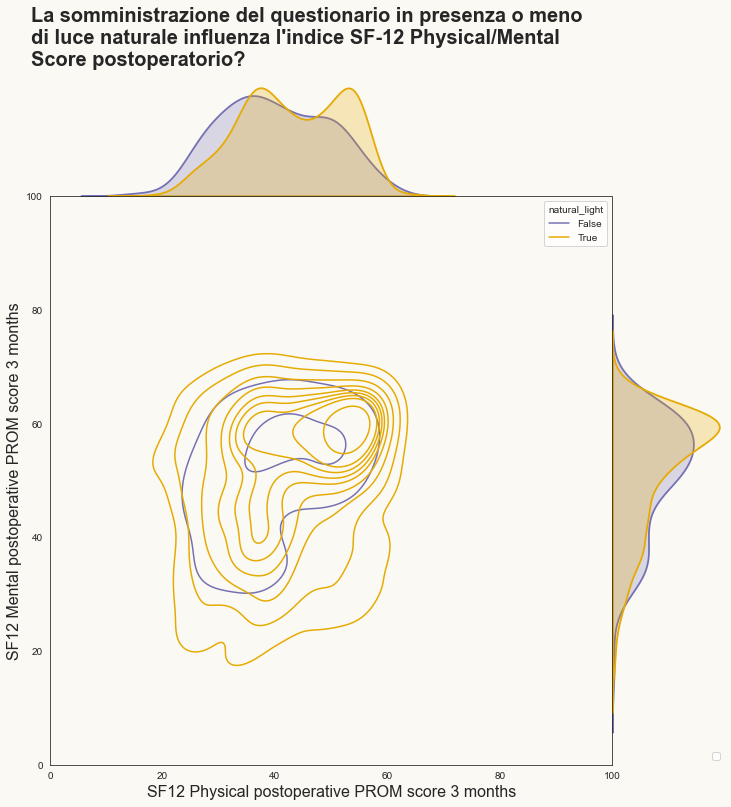

In [22]:
#Codice Remo Marconzini

#definisco la griglia
sns.set_style('white')
g = sns.JointGrid(height=10, space=0.001, xlim=(0,100), ylim=(0,100))
g.fig.patch.set_facecolor('#fbf9f4')
g.ax_joint.patch.set_facecolor('#fbf9f4')
g.ax_marg_x.patch.set_facecolor('#fbf9f4')
g.ax_marg_y.patch.set_facecolor('#fbf9f4')


# creo vettori per plottare la distribuzione congiunta diversificando per la variabile "natural light"
x, y = df1.physical_score_postop, df1.mental_score_postop
#creo due vettori contenenti in uno le osservazioni con natural_light=True, l'altro con le osservazioni 
# con nantural_light=False
x_off, y_off = df1_off.physical_score_postop, df1_off.mental_score_postop
x_on, y_on = df1_on.physical_score_postop, df1_on.mental_score_postop

#distribuzione congiunta dello score mentale e fisico
sns.kdeplot(x=x, y=y, ax=g.ax_joint,hue=df1["natural_light"], palette = {False:'#7570B3', True:'#E6AB02'}, )
plt.legend(loc='lower right')

#plotto la media congiunta dello score mentale e fisico
mean_m = df1['mental_score_postop'].mean()
mean_p = df1['physical_score_postop'].mean()
#g.refline(x=mean_p, y=mean_m, marginal=False)

#distribuzioni marginali light off
sns.kdeplot(x=x_off, ax = g.ax_marg_x, color='#7570B3', linewidth=1.8, fill=True)
sns.kdeplot(y=y_off, ax = g.ax_marg_y, color='#7570B3', linewidth=1.8, fill=True)

#distribuzioni marginali light on
sns.kdeplot(x=x_on, ax = g.ax_marg_x, color='#E6AB02',linewidth=1.8,fill=True)
sns.kdeplot(y=y_on, ax = g.ax_marg_y, color='#E6AB02',linewidth=1.8,fill=True)

#Labels
g.set_axis_labels('SF12 Physical postoperative PROM score 3 months', 'SF12 Mental postoperative PROM score 3 months', fontsize=16)

# Titolo
titolo_italiano = "La somministrazione del questionario in presenza o meno \ndi luce naturale influenza l'indice SF-12 Physical/Mental \nScore postoperatorio?"
titolo_inglese = ""
g.fig.suptitle(
    titolo_italiano,
    x = 0.022,
    y = 1.09,
    ha="left",
    fontsize=20,
    weight="bold",
    wrap = True
)

In [23]:
df1.groupby('natural_light')[['physical_score_postop', 'mental_score_postop']].agg(['count', 'std', 'median', 'mean'])

#z = 1.96
#sunto['mean_conf_interv'] = 2 * z * sunto['std'] / sunto['count']**(1/2)
#sunto['mean_conf_inf'] = sunto['mean'] - z * sunto['std'] / sunto['count']**(1/2)
#sunto['mean_conf_sup'] = sunto['mean'] + z * sunto['std'] / sunto['count']**(1/2)
#
#sunto

physical_score_postop                              \
                              count       std median       mean   
natural_light                                                     
False                           121  9.375033  39.05  40.050579   
True                            934  9.144682  42.97  43.226627   

              mental_score_postop                               
                            count        std median       mean  
natural_light                                                   
False                         121  10.261905  52.85  50.533471  
True                          934  10.506149  55.05  51.773212

Text(0.022, 1.09, "La somministrazione del questionario in presenza o meno \ndi luce naturale influenza l'indice SF-12 Physical/Mental \nScore post-operatorio?")

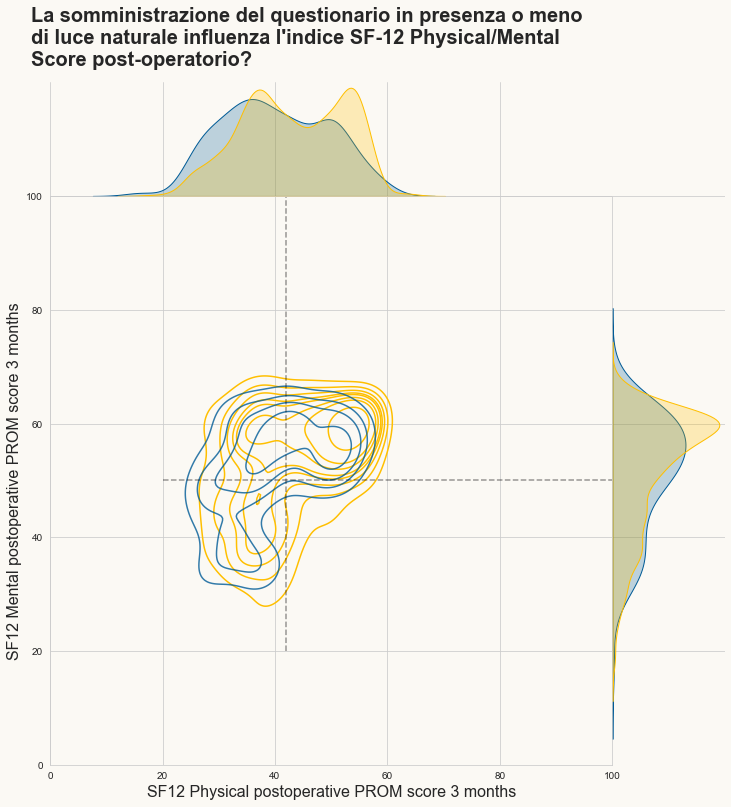

In [249]:
#definisco la griglia
sns.set_style('whitegrid')
g = sns.JointGrid(height=10, space=0.001, xlim=(0,100), ylim=(0,100))
g.fig.patch.set_facecolor('#fbf9f4')
g.ax_joint.patch.set_facecolor('#fbf9f4')
g.ax_marg_x.patch.set_facecolor('#fbf9f4')
g.ax_marg_y.patch.set_facecolor('#fbf9f4')


#creo i vettorie dei due score per on e off
x_off, y_off = df1_off.physical_score_postop, df1_off.mental_score_postop
x_on, y_on = df1_on.physical_score_postop, df1_on.mental_score_postop


#creo i due kde plot
sns.kdeplot(x=x_on,\
            y=y_on,\
            ax=g.ax_joint,\
            thresh = 0.16,\
            levels = 9,\
            bw_adjust = 0.9,\
            color='#ffbf00',\
            #cmap = 'Oranges_d'
            #cmap = None,\
            #colors = shades,\
            #colors = '#E6AB02',\
            #fill = True,\
            )



sns.kdeplot(x=x_off,\
            y=y_off,\
            ax=g.ax_joint,\
            thresh = 0.3,\
            levels = 5,\
            bw_adjust = 0.8,\
            color='#005b96',\
            alpha = 0.8,\
            #cmap = 'Blues'\
            )

#linee verticali ed orizzontali
g.ax_joint.axvline(x=42, ymin=0.2, ymax=1, color = 'black', alpha = 0.4, ls='--')
g.ax_joint.axhline(y=50, xmin=0.2, xmax=1, color = 'black', alpha = 0.4, ls='--')

#distribuzioni marginali physical
sns.kdeplot(x=x_off,\
            ax = g.ax_marg_x,\
            color='#005b96',\
            shade = True,\
            bw_adjust = 0.8\
           )

sns.kdeplot(x=x_on,\
            ax = g.ax_marg_x,\
            color='#ffbf00',\
            shade = True,\
            bw_adjust = 0.75\
           )

#distribuzioni marginali mental
sns.kdeplot(y=y_off,\
            ax = g.ax_marg_y,\
            color='#005b96',\
            shade = True,\
            bw_adjust = 1.1\
           )

sns.kdeplot(y=y_on,\
            ax = g.ax_marg_y,\
            color='#ffbf00',\
            shade = True,\
            bw_adjust = 0.75\
           )

#Labels
g.set_axis_labels('SF12 Physical postoperative PROM score 3 months', 'SF12 Mental postoperative PROM score 3 months', fontsize=16)

# Titolo
titolo_italiano = "La somministrazione del questionario in presenza o meno \ndi luce naturale influenza l'indice SF-12 Physical/Mental \nScore post-operatorio?"
titolo_inglese = ""
g.fig.suptitle(
    titolo_italiano,
    x = 0.022,
    y = 1.09,
    ha="left",
    fontsize=20,
    weight="bold",
    wrap = True
)


array([36.02, 49.48])

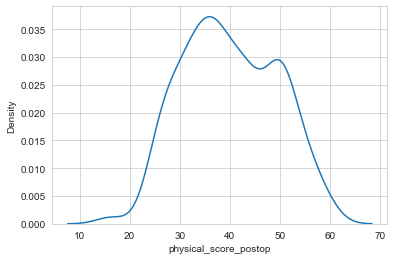

In [159]:
#massimi locali light_false physical
x, y = sns.kdeplot(x=x_off, bw_adjust = 0.8).get_lines()[0].get_data()
x[argrelextrema(y, np.greater)].round(2)

array([37.15, 53.55])

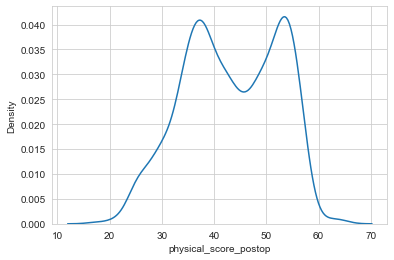

In [157]:
#massimi locali light_true physical
x, y = sns.kdeplot(x=x_on, bw_adjust = 0.75).get_lines()[0].get_data()
x[argrelextrema(y, np.greater)].round(2)

array([56.34])

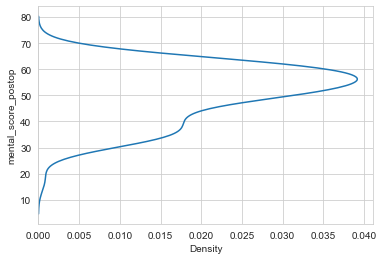

In [160]:
#massimi locali light_false mental
x, y = sns.kdeplot(y=y_off, bw_adjust = 1.1).get_lines()[0].get_data()
y[argrelextrema(x, np.greater)].round(2)

array([59.75])

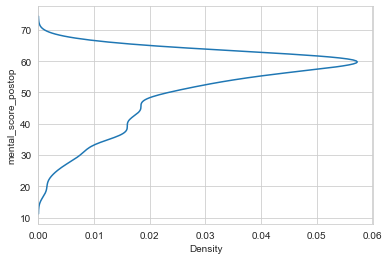

In [161]:
#massimi locali light_true mental
x, y = sns.kdeplot(y=y_on, bw_adjust = 0.75).get_lines()[0].get_data()
y[argrelextrema(x, np.greater)].round(2)